
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# set values if testing
import os

from copy import deepcopy

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian.mggpo import MGGPOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

from xopt.generators.bayesian.objectives import feasibility

from matplotlib import pyplot as plt

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

evaluator = Evaluator(function=evaluate_TNK)
evaluator.max_workers = 10

# test check options
vocs = deepcopy(tnk_vocs)
gen = MGGPOGenerator(vocs=vocs, reference_point={"y1": 1.5, "y2": 1.5})
gen.n_monte_carlo_samples = N_MC_SAMPLES
gen.numerical_optimizer.n_restarts = NUM_RESTARTS
gen.gp_constructor.use_low_noise_prior = True
X = Xopt(evaluator=evaluator, generator=gen, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.75, 1.0]}))

X


            Xopt
________________________________
Version: 0.0.0
Data size: 2
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 10
  vectorized: false
generator:
  computation_time: null
  custom_objective: null
  fixed_features: null
  ga_generator:
    crossover_probability: 0.9
    mutation_probability: 1.0
    output_path: null
    population: null
    population_file: null
    population_size: 64
    supports_constraints: true
    supports_multi_objective: true
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_cached_hyperparameters: false
    use_low_noise_prior: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: mggpo
  numerical_optimiz

In [2]:
for i in range(10):
    print(i)
    X.step()

0
1
2
3
4
5
6
7
8
9


In [3]:
X.generator.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.000000,0.750000,dummy_constant,1.000000,0.750000,0.626888,0.312500,0.000032,False
1,0.750000,1.000000,dummy_constant,0.750000,1.000000,0.626888,0.312500,0.000007,False
2,1.686528,0.184445,dummy_constant,1.686528,0.184445,1.895521,1.507424,0.000029,False
3,1.622960,0.220102,dummy_constant,1.622960,0.220102,1.737739,1.339381,0.000008,False
4,1.582201,0.112544,dummy_constant,1.582201,0.112544,1.473920,1.321281,0.000007,False
...,...,...,...,...,...,...,...,...,...
97,0.880599,0.515992,dummy_constant,0.880599,0.515992,0.100333,0.145111,0.000005,False
98,0.183993,0.981425,dummy_constant,0.183993,0.981425,0.095496,0.331630,0.000004,False
99,0.830116,0.564823,dummy_constant,0.830116,0.564823,0.107213,0.113179,0.000004,False
100,0.822966,0.553496,dummy_constant,0.822966,0.553496,0.083514,0.107169,0.000004,False


## plot results


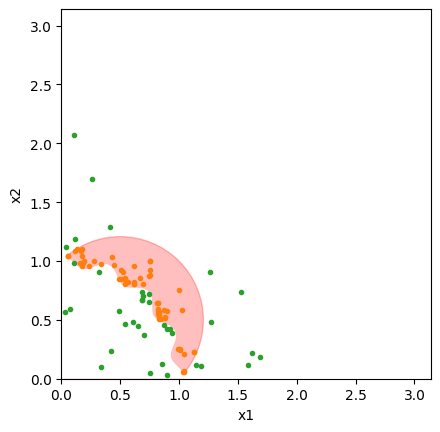

In [4]:
fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5**0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


(<Figure size 800x1980 with 22 Axes>,
 array([[<Axes: title={'center': 'Posterior Mean [y1]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [y1]'}>],
        [<Axes: title={'center': 'Posterior Mean [y2]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [y2]'}>],
        [<Axes: title={'center': 'Posterior Mean [c1]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [c1]'}>],
        [<Axes: title={'center': 'Posterior Mean [c2]'}, ylabel='x2'>,
         <Axes: title={'center': 'Posterior SD [c2]'}>],
        [<Axes: title={'center': 'Acq. Function'}, ylabel='x2'>, <Axes: >],
        [<Axes: title={'center': 'Feasibility'}, xlabel='x1', ylabel='x2'>,
         <Axes: xlabel='x1'>]], dtype=object))

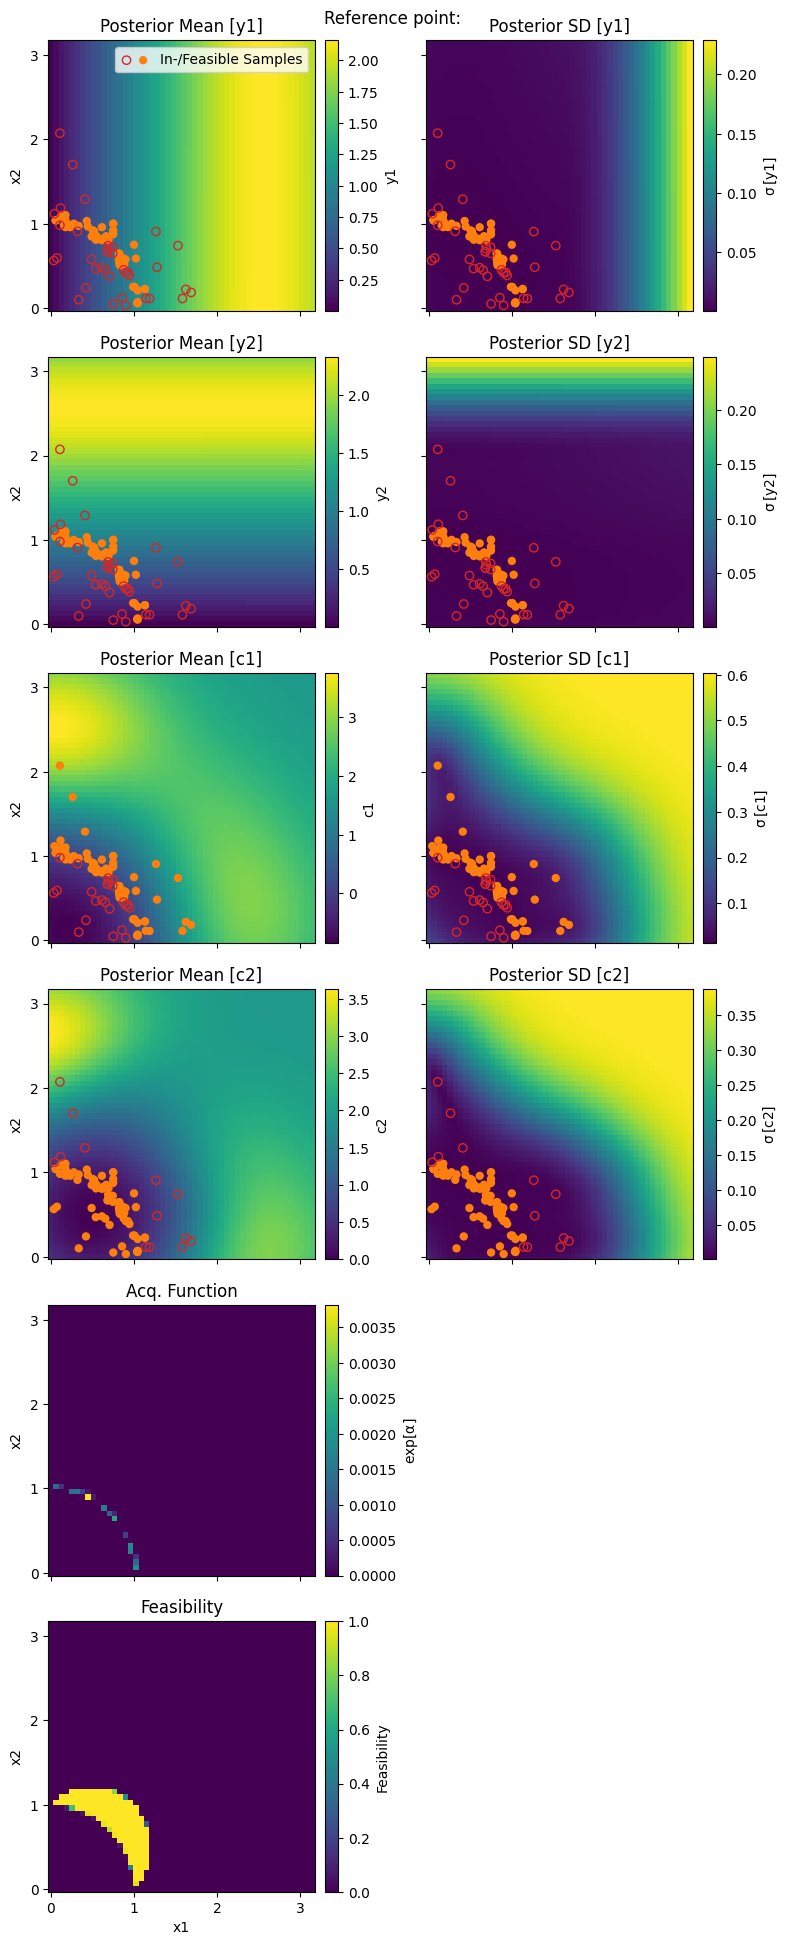

In [5]:
X.generator.visualize_model(show_feasibility=True)

In [6]:
X.generator.pareto_front_history

,hypervolume,n_non_dominated
1,0.500000,2
11,0.728605,3
21,0.999297,4
31,1.027674,6
41,1.105700,7
51,1.176762,10
61,1.298883,9
71,1.317093,9
81,1.340492,9
91,1.347864,11
